In [1]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model

In [2]:
image_directory = r'D:\Projects\ODIR\ODIRCODE\PreprocessingCodes\Input_224/'


#Now let us read metadata to get our Y values (multiple lables)
df = pd.read_csv(r'D:\Projects\ODIR\ODIRCODE\Prepro\ground_truth\all\odirALL.csv')    
print(df.head())     # printing first five rows of the file
print(df.columns)

df = df.iloc[:23000]  #Loading only first 1000 datapoints for memory reasons 
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to 
#the metadata from the csv file. 

            ID  Normal  Diabetes  Glaucoma  Cataract  AMD  Hypertension  \
0   0_left.jpg       0         0         0         1    0             0   
1  0_right.jpg       1         0         0         0    0             0   
2   1_left.jpg       1         0         0         0    0             0   
3  1_right.jpg       1         0         0         0    0             0   
4   2_left.jpg       0         1         0         0    0             0   

   Myopia  Others  Total  
0       0       0      1  
1       0       0      1  
2       0       0      1  
3       0       0      1  
4       0       1      2  
Index(['ID', 'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD',
       'Hypertension', 'Myopia', 'Others', 'Total'],
      dtype='object')


In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
SIZE = 224
X_dataset = []  
for i in tqdm(range(df.shape[0])):
    img = load_img(image_directory +df['ID'][i], target_size=(SIZE,SIZE,3))   
    img = img_to_array(img)
    img = img/255.
    X_dataset.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 22032/22032 [01:27<00:00, 251.23it/s]


In [4]:
X = np.array(X_dataset)

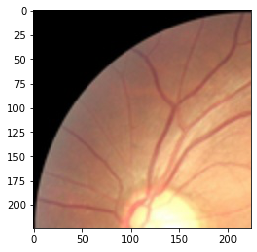

In [5]:
from matplotlib import pyplot as plt
plt.imshow(X[21000], interpolation='nearest')
plt.show()

In [6]:
#
print(df['ID'][500])  #King Kong

print(df['Total'][500])  #Tagged as multiple Genres.

#Id and Genre are not labels to be trained. So drop them from the dataframe.

268_left.jpg
2


In [7]:
y = np.array(df.drop(['ID', 'Total'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [8]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten
checkpoint1 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\resnet101\my_best_model.epoch{epoch:03d}-loss{val_loss:.2f}.hdf5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
checkpoint2 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\resnet101\my_best_model.epoch{epoch:03d}-acc{val_accuracy:.2f}.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint1,checkpoint2]
res=tf.keras.applications.resnet.ResNet101(include_top=False,weights='imagenet',input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=8)

#inc=InceptionV3(input_shape=(200,200,3),weights='imagenet', include_top=False)
for i in res.layers:
    i.trainable=True
x=Flatten()(res.output)
pred=Dense(8,activation='sigmoid')(x)
model=Model(inputs=res.input,outputs=pred)

In [9]:
model.summary()

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=150,callbacks=callbacks, validation_data=(X_test, y_test), batch_size=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Train on 15422 samples, validate on 6610 samples
Epoch 1/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.8554
Epoch 00001: val_loss improved from inf to 0.39365, saving model to D:\Projects\ODIR\ODIRCODE\bestres\resnet101\my_best_model.epoch001-loss0.39.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.86282, saving model to D:\Projects\ODIR\ODIRCODE\bestres\resnet101\my_best_model.epoch001-acc0.86.hdf5
15422/15422 [==============================] - 178s 12ms/sample - loss: 0.3768 - accuracy: 0.8554 - val_loss: 0.3936 - val_accuracy: 0.8628
Epoch 2/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8735
Epoch 00002: val_loss did not improve from 0.39365

Epoch 00002: val_accuracy did not improve from 0.86282
15422/15422 [==============================] - 159s 10ms/sample - loss: 0.2939 - accuracy: 0.8735 - val_loss: 0.3989 - val_accuracy: 0.8414
Epoch 3/150
15420/15422 [============================>.] - 

Epoch 21/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9847
Epoch 00021: val_loss did not improve from 0.28070

Epoch 00021: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0411 - accuracy: 0.9847 - val_loss: 0.5288 - val_accuracy: 0.8860
Epoch 22/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9853
Epoch 00022: val_loss did not improve from 0.28070

Epoch 00022: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0388 - accuracy: 0.9853 - val_loss: 0.5719 - val_accuracy: 0.8855
Epoch 23/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9867
Epoch 00023: val_loss did not improve from 0.28070

Epoch 00023: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0354 - accuracy: 0.

Epoch 45/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9950
Epoch 00045: val_loss did not improve from 0.28070

Epoch 00045: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0143 - accuracy: 0.9950 - val_loss: 1.0750 - val_accuracy: 0.8764
Epoch 46/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9959
Epoch 00046: val_loss did not improve from 0.28070

Epoch 00046: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0117 - accuracy: 0.9959 - val_loss: 1.2002 - val_accuracy: 0.8738
Epoch 47/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9952
Epoch 00047: val_loss did not improve from 0.28070

Epoch 00047: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0137 - accuracy: 0.

Epoch 69/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9973
Epoch 00069: val_loss did not improve from 0.28070

Epoch 00069: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.9190 - val_accuracy: 0.8865
Epoch 70/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9969
Epoch 00070: val_loss did not improve from 0.28070

Epoch 00070: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.7906 - val_accuracy: 0.8915
Epoch 71/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9969
Epoch 00071: val_loss did not improve from 0.28070

Epoch 00071: val_accuracy did not improve from 0.89402
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0091 - accuracy: 0.

Epoch 116/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00116: val_loss did not improve from 0.28070

Epoch 00116: val_accuracy did not improve from 0.89453
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 1.0397 - val_accuracy: 0.8844
Epoch 117/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9984
Epoch 00117: val_loss did not improve from 0.28070

Epoch 00117: val_accuracy did not improve from 0.89453
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.9660 - val_accuracy: 0.8889
Epoch 118/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9988
Epoch 00118: val_loss did not improve from 0.28070

Epoch 00118: val_accuracy did not improve from 0.89453
15422/15422 [==============================] - 156s 10ms/sample - loss: 0.0037 - accuracy:

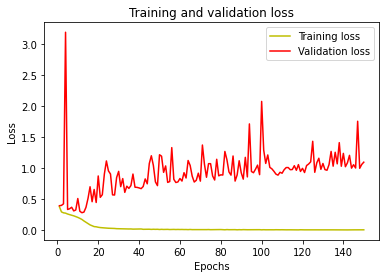

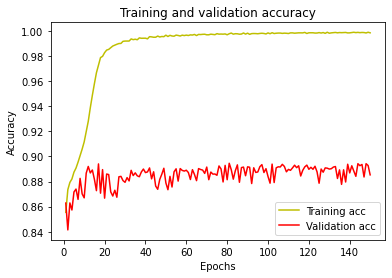

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# MLP for Pima Indians Dataset saved to single file
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model.save(r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\modelke.h5")
print("Saved model to disk")
# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save(r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\ke2model.h5")
print("Saved model to disk")

Saved model to disk
accuracy: 99.00%
Saved model to disk


In [12]:
...
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\model2.h5")

In [13]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense
import numpy
import os

# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# serialize model to JSON
model_json = model.to_json()
with open(r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\modeljs.h5")
print("Saved model to disk")


accuracy: 99.00%
Saved model to disk


In [14]:
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import Dense
import numpy
import os

# serialize model to YAML
model_yaml = model.to_yaml()
with open(r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\Resnet101\final\modelya.h5")
print("Saved model to disk")
 


Saved model to disk
